(2048,)


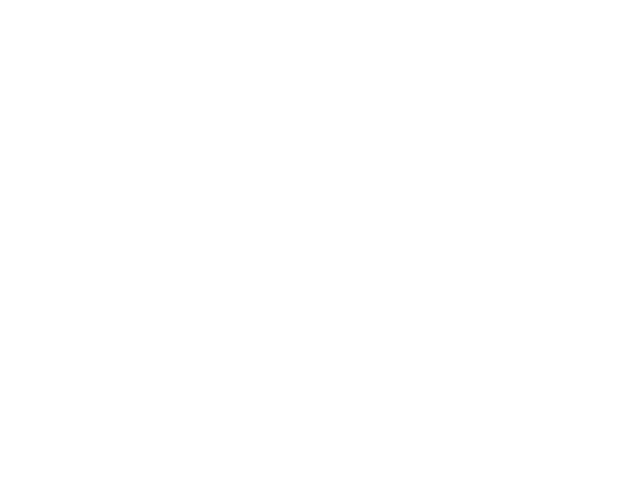

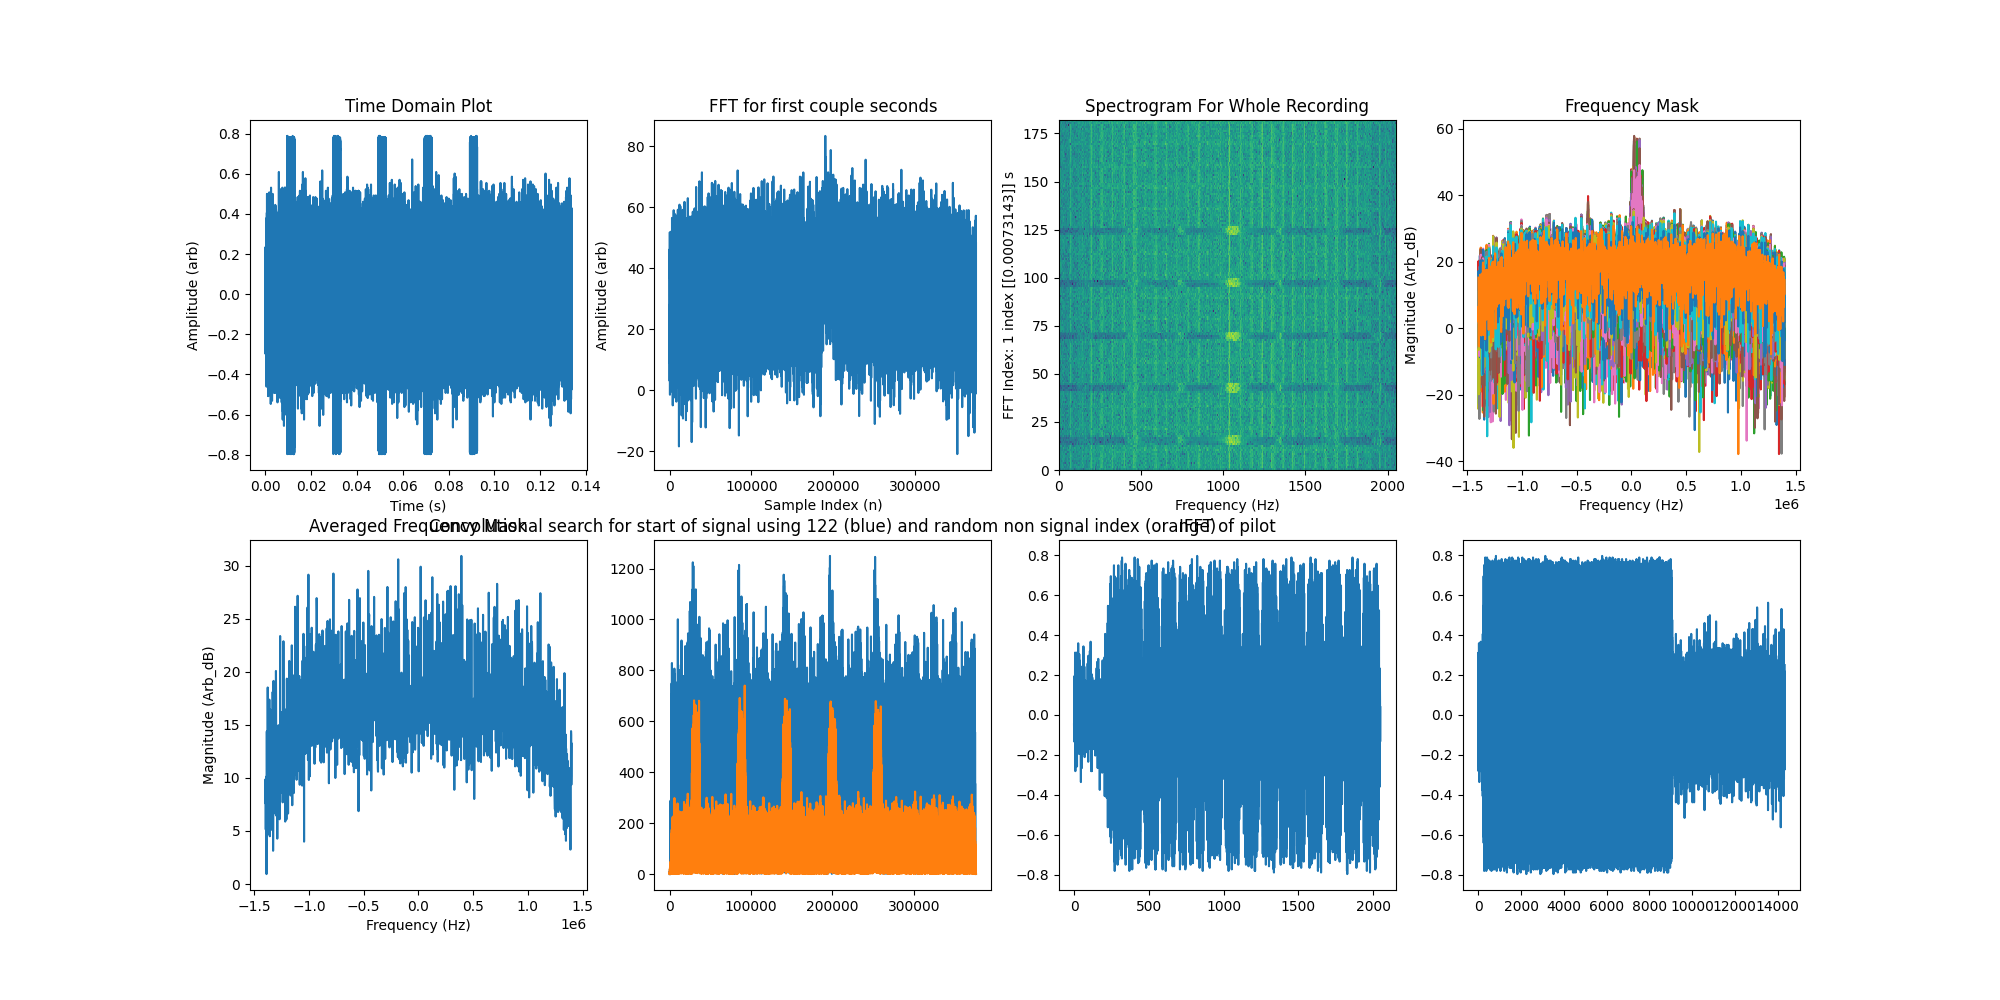

In [11]:
%matplotlib widget

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal

data = scipy.io.loadmat('data_375000samp_2800000MSPS_867890000.mat')

plt.clf()
plt.ion()

cf = data['centre_freq']
fs = data['sample_rate']
iq = data['output']
iq = np.array(iq, dtype=np.complex128)
iq = np.squeeze(iq)

time_to_plot_seconds = 20

fft_size = 512*4

samples_to_cut = 124*4
iq = iq[samples_to_cut:]
samples_to_plot = len(iq)

time_axis = np.reshape(np.linspace(1, samples_to_plot, samples_to_plot)*1/fs, (len(iq),1))
frequency_axis = np.reshape(((np.linspace(1, fft_size, fft_size)- int(fft_size/2))*int(fs/fft_size)) , (fft_size,1))
                         
fig, ax = plt.subplots(2,4, figsize=(20, 10))

ax[0,0].plot(time_axis, np.real(iq[:samples_to_plot]))
ax[0,0].set_xlabel("Time (s)")
ax[0,0].set_ylabel("Amplitude (arb)")
ax[0,0].set_title("Time Domain Plot")

ax[0,1].plot(20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(iq)))))
ax[0,1].set_xlabel("Sample Index (n)")
ax[0,1].set_ylabel("Amplitude (arb)")
ax[0,1].set_title("FFT for first couple seconds")

# number of frame in spectrogram
spectrogram_samples = int((len(iq)-np.mod(len(iq),fft_size))/fft_size)
spectrogram_data = np.empty((spectrogram_samples,fft_size))
for i in range(spectrogram_samples):

    spectrogram_data[i,:] = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(iq[i*fft_size: (i+1)*fft_size])))) 

a = np.squeeze(np.reshape(np.linspace(1,spectrogram_samples,spectrogram_samples),(spectrogram_samples,1)))

x = np.linspace(0,spectrogram_samples,spectrogram_samples)
y = ((np.linspace(0, fft_size, fft_size)- int(fft_size/2))*int(fs/fft_size))
ax[0,2].pcolormesh(spectrogram_data)
ax[0,2].set_xlabel("Frequency (Hz)")
ax[0,2].set_ylabel(f"FFT Index: 1 index {fft_size/fs} s" )
ax[0,2].set_title("Spectrogram For Whole Recording")


for i in range(spectrogram_samples):
    ax[0,3].plot(frequency_axis, spectrogram_data[i,:])

ax[0,3].set_title("Frequency Mask")
ax[0,3].set_xlabel("Frequency (Hz)")
ax[0,3].set_ylabel("Magnitude (Arb_dB)")

ax[1,0].plot(frequency_axis, np.mean(spectrogram_data[26:35,:], axis=0))
ax[1,0].set_title("Averaged Frequency Mask")
ax[1,0].set_xlabel("Frequency (Hz)")
ax[1,0].set_ylabel("Magnitude (Arb_dB)")

burst_spectrogram_data = np.empty((spectrogram_samples,fft_size), dtype=np.complex128)
for i in range(spectrogram_samples):

    burst_spectrogram_data[i,:] = np.fft.fftshift(np.fft.fft(iq[i*fft_size: (i+1)*fft_size]))

#cf estimation off by 50 KHZ
pilot_fft_start_index = 122
extract_length = 5
pilot = burst_spectrogram_data[pilot_fft_start_index,:]
not_pilot = burst_spectrogram_data[50,:]
print(np.shape(pilot))
a = np.convolve(iq, np.flip(pilot))
b = np.convolve(iq, np.flip(not_pilot))
ax[1,1].plot(np.abs(a))
ax[1,1].plot(np.abs(b))
ax[1,1].set_title(f"Convolutional search for start of signal using {pilot_fft_start_index} (blue) and random non signal index (orange)")

ax[1,2].plot(np.real(np.fft.ifft(pilot)))
ax[1,2].set_title(f"IFFT of pilot")

first_pulse = burst_spectrogram_data[pilot_fft_start_index:pilot_fft_start_index+extract_length+2,:]
first_pulse_time = np.reshape(np.real(np.fft.ifft(first_pulse)),((extract_length+2)*fft_size,1))

# index_to_keep = 260
# first_pulse[:, :index_to_keep-1] = 0
# first_pulse[:, index_to_keep + 1:] = 0

ax[1,3].plot(np.reshape(np.real(np.fft.ifft(first_pulse)),((extract_length+2)*fft_size,1)))



In [2]:
# index_to_keep = 1060

# first_pulse_duplicate = np.array(first_pulse)
# fig, ax = plt.subplots(2,1, figsize=(20, 10))

# ax[0].pcolormesh(20*np.log10(np.abs(first_pulse_duplicate)))
# ax[1].plot(np.reshape(np.real(np.fft.ifft(np.fft.fftshift(first_pulse_duplicate))),(extract_length*fft_size,1)))


14136


Text(0.5, 1.0, 'Amplitude of fft across frames')

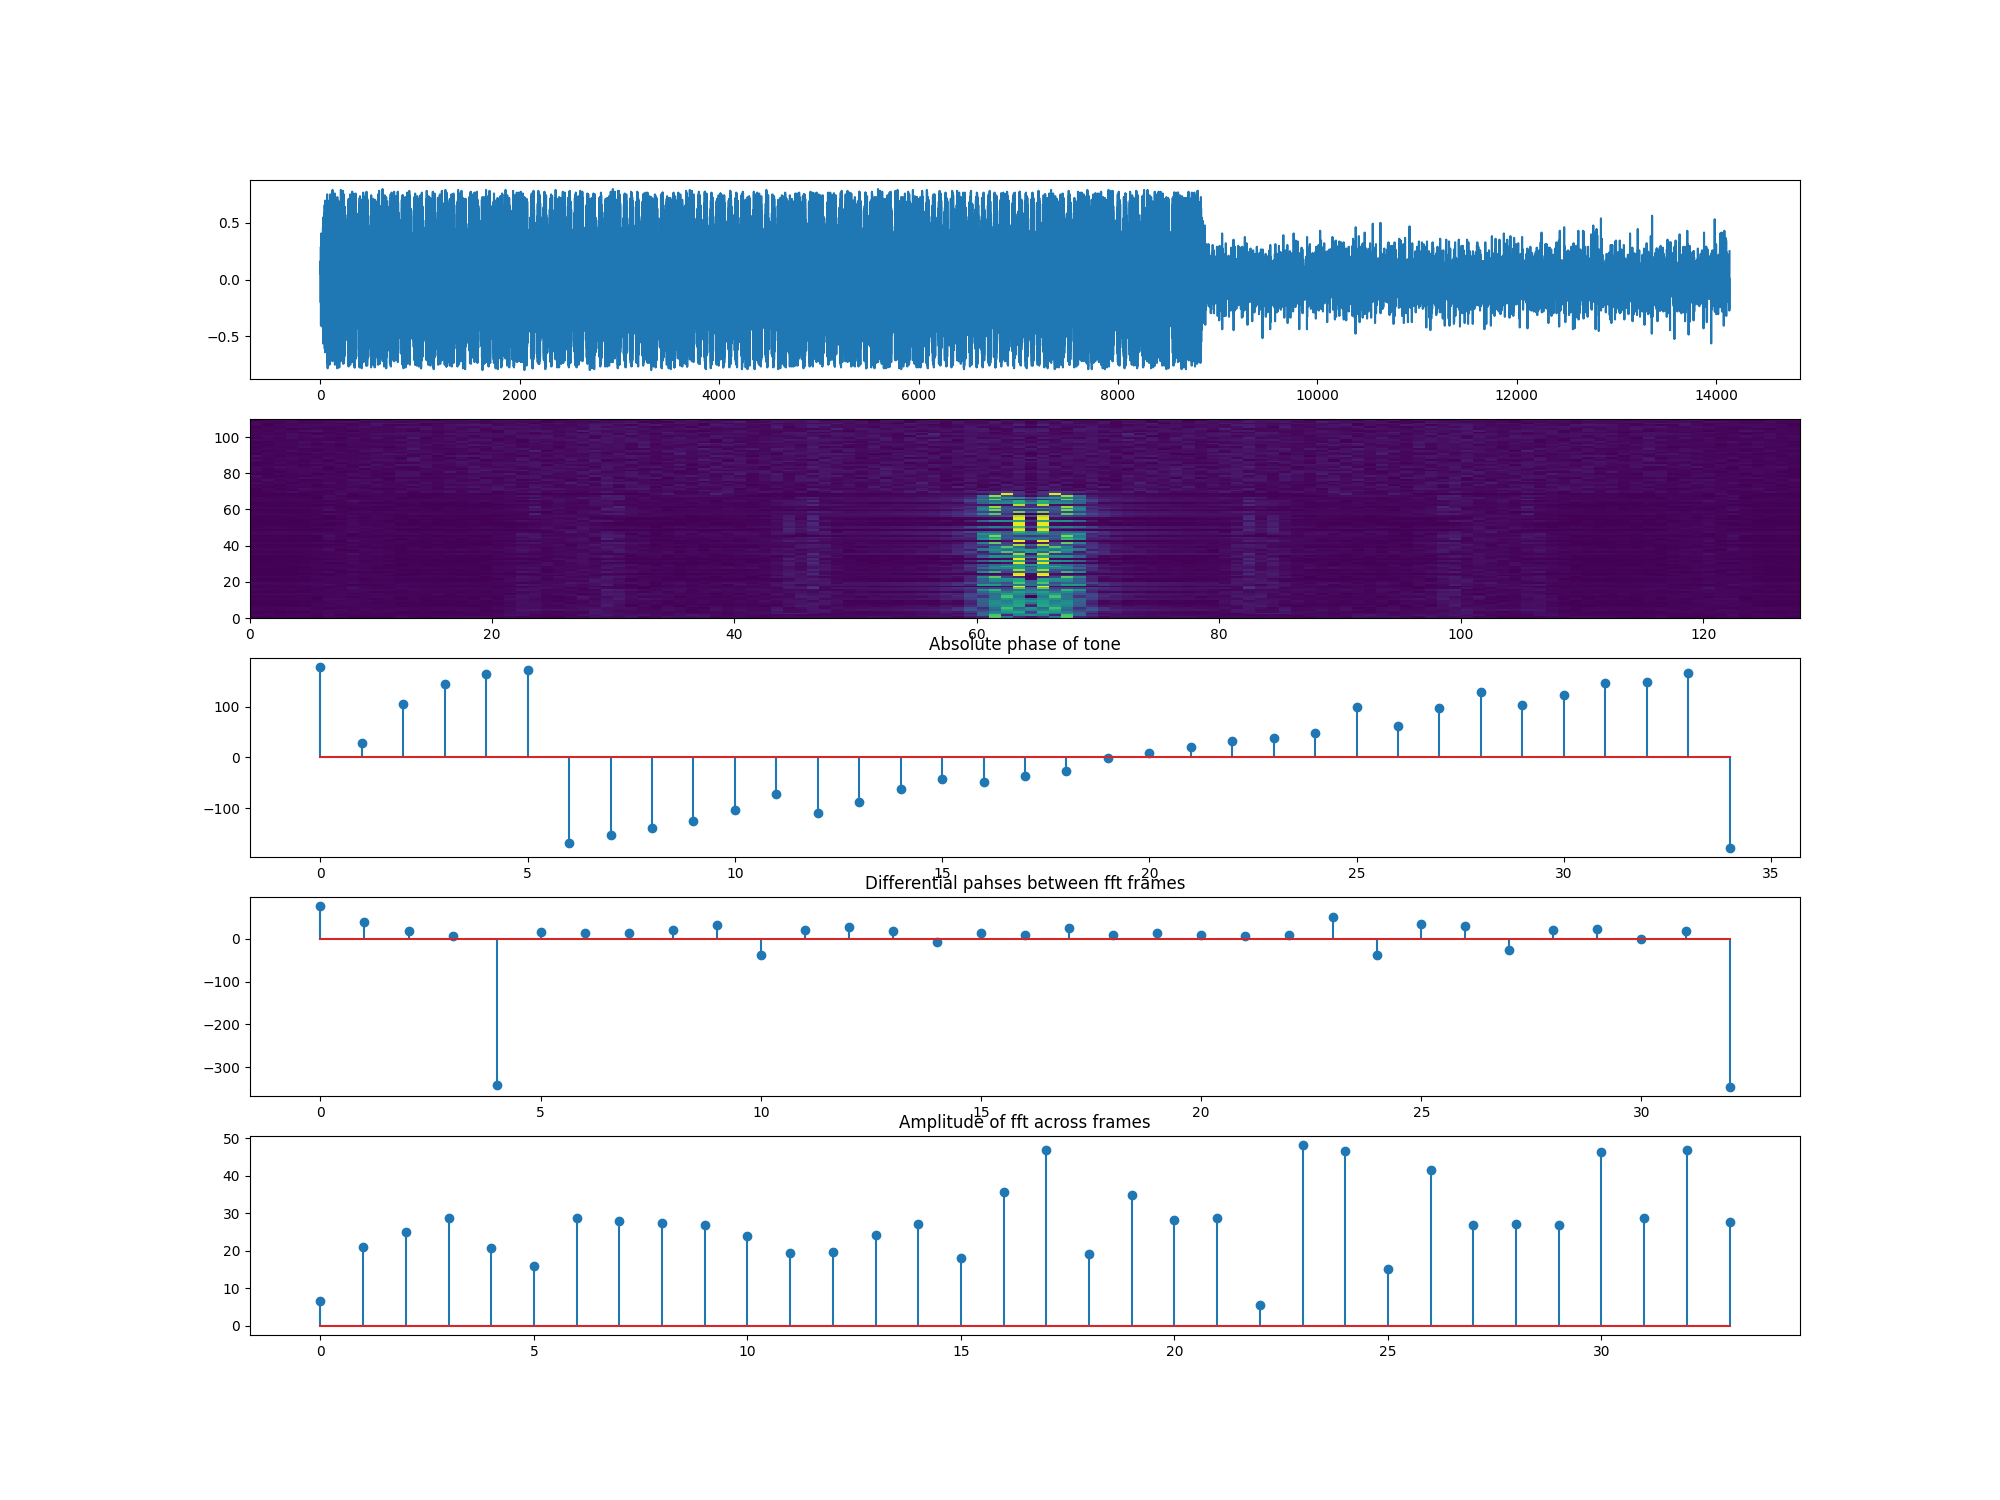

In [12]:

fig, ax = plt.subplots(5,1, figsize=(20, 15))

first_pulse_duplicate = np.array(first_pulse_time[200:])

ax[0].plot(first_pulse_duplicate)

print(len(first_pulse_duplicate))
new_fft_size = 128
new_spectrogram_samples = int(len(first_pulse_duplicate)/new_fft_size)

new_burst_spectrogram_data = np.empty((new_spectrogram_samples,new_fft_size), dtype=np.complex128)
for i in range(new_spectrogram_samples):

    new_burst_spectrogram_data[i,:] = np.squeeze((np.fft.fft(np.squeeze(first_pulse_duplicate[i*new_fft_size: (i+1)*new_fft_size]))))

a = np.fft.fft(new_burst_spectrogram_data, axis=0)

# fig, ax = plt.subplots(2,1, figsize=(20, 10))

#ax[1].plot(np.abs(np.fft.fftshift((np.fft.fft(np.squeeze(first_pulse_duplicate[0:new_fft_size]))))))
ax[1].pcolormesh(np.abs(new_burst_spectrogram_data))

ax[2].stem(np.angle(new_burst_spectrogram_data[:35,65], deg = True))
ax[2].set_title("Absolute phase of tone")

ax[3].stem(np.diff(np.angle(new_burst_spectrogram_data[1:35,65], deg=True)))
ax[3].set_title("Differential pahses between fft frames")

ax[4].stem(np.abs(new_burst_spectrogram_data[:34,65]))
ax[4].set_title("Amplitude of fft across frames")


In [13]:


print(np.size(new_burst_spectrogram_data))
result_string = ""
for i in range(np.shape(new_burst_spectrogram_data)[0]):
    a = [ new_burst_spectrogram_data[i, 65], new_burst_spectrogram_data[i, 67]]
    pmax_index = np.argmax(a)
    result_string += str(pmax_index)

print(result_string)




14080
10111111100101100000000000010011111111111000010000000000011011111011010000010000011110001111000001110011111110


## Pulse Data

### Pulse 1
100010111111111011000010010000000101111111101100000000000100101100110010001101110011101000010100011111100010010

### Pulse 2
100001011111111011011100000000000101111110100101100000000100110010110001000011000000111010110111111110011

### Pulse 3
100000111111111011000010010000000001011111101101000001100010000011010000011100111111010110110000111011

### Pulse 4
111111110010110000000010011011111111111011000000000000001110101110110000101111000111100011100000001000000110101

### Pulse 5
10111111100101100000000000010011111111111000010000000000011011111011010000010000011110001111000001110011111110
